In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pdb import set_trace

import torch
from torch import nn, optim
from torch.nn import functional as F
from dataset import get_mnist, get_cifar10
from train import trainer
from test import tester

os.environ['KERAS_BACKEND'] = 'torch'
import keras
from keras import layers, models

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

device

'cuda'

### mnist

In [3]:
loader = get_mnist(batch_size=32)
len(loader[0]), len(loader[1])

(1875, 313)

In [4]:
x, y = next(iter(loader[0]))
x.shape, y.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [5]:
class Model(nn.Module):
    
    def __init__(self, num_classes=10):
        super().__init__()
        
        self.model = keras.Sequential([layers.Input((1, 28, 28)),
                                       layers.Flatten(),
                                       layers.Dense(200, activation="relu"),
                                       layers.Dense(150, activation="relu"),
                                       layers.Dense(num_classes)])
    
    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        x = self.forward(x)
        pred_y = F.softmax(x, dim=1)
        pred_class = torch.argmax(pred_y, dim=1)
        return pred_class.cpu()

In [6]:
model = Model()
print(model.model.summary())
pred_y = model(x)
pred_y.shape

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       157,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 188,660 (736.95 KB)

 Trainable params: 188,660 (736.95 KB)

 Non-trainable params: 0 (0.00 B)

None


torch.Size([32, 10])

In [7]:
learning_rate = 5e-4
epochs = 10
model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [8]:
model, train_loss = trainer(model, loader[0], epochs, 
                            optimizer, loss_fn, device)
model.training

100%|██████████| 10/10 [02:23<00:00, 14.36s/it]


False

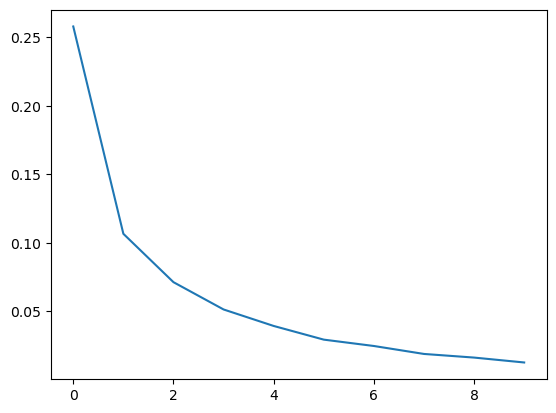

In [9]:
plt.plot(train_loss)
plt.show()

In [10]:
labels, preds = tester(model, loader[1], device)
acc = accuracy_score(labels, preds)
print("Test accuracy: ", round(100*acc, 2))

Test accuracy:  97.79


### cifar10

In [11]:
loader = get_cifar10(batch_size=32)
len(loader[0]), len(loader[1])

Files already downloaded and verified
Files already downloaded and verified


(1562, 313)

In [12]:
x, y = next(iter(loader[0]))
x.shape, y.shape

(torch.Size([32, 32, 32, 3]), torch.Size([32]))

In [13]:
class Model(nn.Module):
    
    def __init__(self, num_classes=10):
        super().__init__()
        input_layer = layers.Input((32, 32, 3))
        x = layers.Flatten()(input_layer)
        x = layers.Dense(200, activation="relu")(x)
        x = layers.Dense(150, activation="relu")(x)
        output_layer = layers.Dense(num_classes)(x)
        self.model =  models.Model(input_layer, output_layer)
    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        x = self.forward(x)
        pred_y = F.softmax(x, dim=1)
        pred_class = torch.argmax(pred_y, dim=1)
        return pred_class.cpu()

In [14]:
model = Model()
print(model.model.summary())
pred_y = model(x)
pred_y.shape

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │       614,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,260 (2.47 MB)

 Trainable params: 646,260 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

None


torch.Size([32, 10])

In [15]:
learning_rate = 5e-4
epochs = 20
model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [16]:
model, train_loss = trainer(model, loader[0], epochs, 
                            optimizer, loss_fn, device)
model.training

100%|██████████| 20/20 [04:52<00:00, 14.63s/it]


False

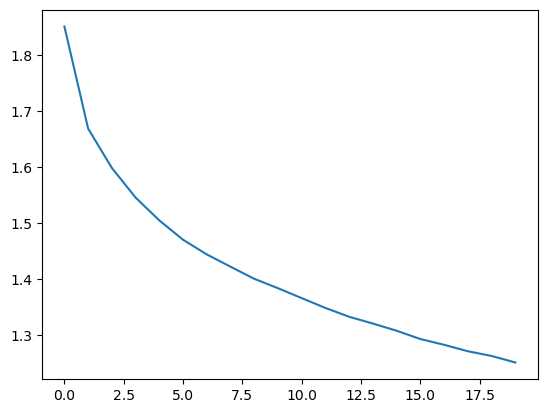

In [17]:
plt.plot(train_loss)
plt.show()

In [18]:
labels, preds = tester(model, loader[1], device)
acc = accuracy_score(labels, preds)
print("Test accuracy: ", round(100*acc, 2))

Test accuracy:  50.91
